In [1]:
%load_ext lab_black

In [2]:
import pickle
from pathlib import Path
from typing import Union, Dict, Optional, List
from collections import defaultdict
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tqdm import tqdm

from camelsml.metrics import calc_nse

In [3]:
plt.style.use("../figstyle.mplstyle")

In [4]:
def load_results(folder: Union[Path, str], model_type: str, seed: int) -> Dict:
    if isinstance(folder, str):
        folder = Path(folder)
    if not folder.exists():
        raise FileNotFoundError(f"No directory found at {folder}")
    nse_values = defaultdict(dict)
    epochs = len(list(folder.rglob(f"{model_type}_seed{seed}_epoch_*.p")))
    if epochs == 0:
        raise FileNotFoundError(f"No validation runs found")
    for epoch in range(1, epochs + 1):
        file = folder / f"{model_type}_seed{seed}_epoch_{epoch}.p"
        with open(file, "rb") as results_file:
            results = pickle.load(results_file)
        for basin in results.keys():
            nse_values[f"epoch_{epoch}"][basin] = calc_nse(
                obs=results[basin]["qobs"].to_numpy(),
                sim=results[basin]["qsim"].to_numpy(),
            )
    return nse_values


def load_cv_results(
    main_folder: Union[Path, str], k, model_type: str, seed: int, epoch: int = 30
) -> Dict:
    if isinstance(main_folder, str):
        main_folder = Path(main_folder)
    if not main_folder.exists():
        raise FileNotFoundError(f"No directory found at {main_folder}")
    results = {}
    full_results = defaultdict(dict)
    for i in tqdm(range(k)):
        folder = main_folder / str(i)
        folder = list(folder.glob("*"))
        if len(folder) != 1:
            warnings.warn(f"Check your file structure in {i}")
        folder = folder[0]
        results[i] = load_results(folder, model_type, seed)
        for key in list(results[i].keys())[:epoch]:
            for basin in results[i][key].keys():
                full_results[key][basin] = results[i][key][basin]
    return full_results

In [221]:
def parse_results(
    folder: Union[str, Path], k: int = 5, skip: Optional[Union[int, List[int]]] = None
) -> Dict:
    if isinstance(skip, int):
        skip = [skip]
    folder = Path(folder)
    results = []
    for i in range(k):
        if not skip is None and i in skip:
            continue
        file = folder / f"{i}" / "i_list.pickle"
        with open(file, "rb") as infile:
            results.append(pickle.load(infile))
    return results


def calc_i(
    permutations: List,
    nse_values: Dict,
    epoch: int = 30,
    k: int = 5,
    min_nse=0,
    skip: Optional[Union[int, List[int]]] = None,
) -> pd.DataFrame:
    if isinstance(skip, int):
        skip = [skip]
    features = list(permutations[0].keys())  # permutations.keys()[0]])
    nse_values = nse_values[f"epoch_{epoch}"]
    means = defaultdict(lambda: defaultdict(lambda: 0))
    index = -1
    debug_counter = 0
    for i in range(k):
        if not skip is None and i in skip:
            print(f"skipped {i}!")
            index += 1
            continue
        else:
            index += 1
        fold = permutations[index]
        # features = list(fold.keys())
        for feature in features:
            feature_results = fold[feature]
            for k_ in list(feature_results.keys()):
                # print(k_, len(list(feature_results.keys())))
                for basin in feature_results[k_].keys():
                    means[feature][basin] += feature_results[k_][basin] / len(
                        list(feature_results.keys())
                    )

    for feature in features:
        for basin in means[feature].keys():
            if basin == "56012":
                # print(basin)
                debug_counter += 1
            if nse_values[basin] >= min_nse:
                means[feature][basin] = nse_values[basin] - means[feature][basin]
            else:
                means[feature][basin] = np.nan
    return pd.DataFrame.from_dict(means).dropna()

In [230]:
k = 5
permutations = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_cv/permutation/",
    k=k,
)
nse_values = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_cv/",
    model_type="ealstm",
    seed="19970204",
    k=k,
)
importance_all_features = calc_i(permutations, nse_values, k=k, min_nse=0.5, epoch=20)

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


In [231]:
print(importance_all_features.idxmin())
nse_values["epoch_30"]["39036"]

gauge_easting     39127
gauge_northing    39127
gauge_elev        39127
area              39127
elev_min          39127
                  ...  
frac_mod_perc     27077
frac_low_perc     54017
no_gw_perc        42004
low_nsig_perc     39127
nsig_low_perc     39127
Length: 76, dtype: object


-20.826532323937354

In [232]:
def importance_metrics(importances: pd.DataFrame, limit: float = 0.1) -> pd.DataFrame:
    fracs = defaultdict(dict)
    for feature in importances.columns:
        fracs[feature][f"Amount i > {limit}"] = (importances[feature] > limit).sum()
        fracs[feature][f"Fraction i > {limit}"] = fracs[feature][
            f"Amount i > {limit}"
        ] / len(importances[feature])
        fracs[feature][f"Max"] = importances[feature].max()
        fracs[feature][
            "|i|"
        ] = f"{importances[feature].mean():.4f}+-{importances[feature].std():.2f}"
        fracs[feature][f"median(i)"] = np.median(importances[feature])
    df = pd.DataFrame.from_dict(fracs).T.sort_values(
        f"Fraction i > {limit}", ascending=False
    )
    return df


fracs_all_features = importance_metrics(importance_all_features, limit=0.1)
fracs_all_features

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
Q95,260,0.55794,1480.14,6.1349+-71.60,0.124402
baseflow_index_ceh,242,0.519313,11.1204,0.3451+-0.97,0.104839
p_mean,188,0.403433,2.93921,0.1394+-0.25,0.0704632
Q5,119,0.255365,12.2972,0.2394+-0.91,0.0273929
aridity,94,0.201717,1.0703,0.0615+-0.12,0.0278304
...,...,...,...,...,...
soil_depth_pelletier_50,28,0.0600858,0.832855,0.0246+-0.08,0.00761195
root_depth_95,28,0.0600858,1.05541,0.0256+-0.09,0.00676379
elev_min,28,0.0600858,0.984235,0.0284+-0.10,0.00878785
frac_mod_perc,27,0.0579399,0.920845,0.0231+-0.09,0.00644931


Q95 b'Q95'
baseflow\_index\_ceh b'baseflow\\_index\\_ceh'
porosity\_hypres\_5 b'porosity\\_hypres\\_5'
num\_reservoir b'num\\_reservoir'


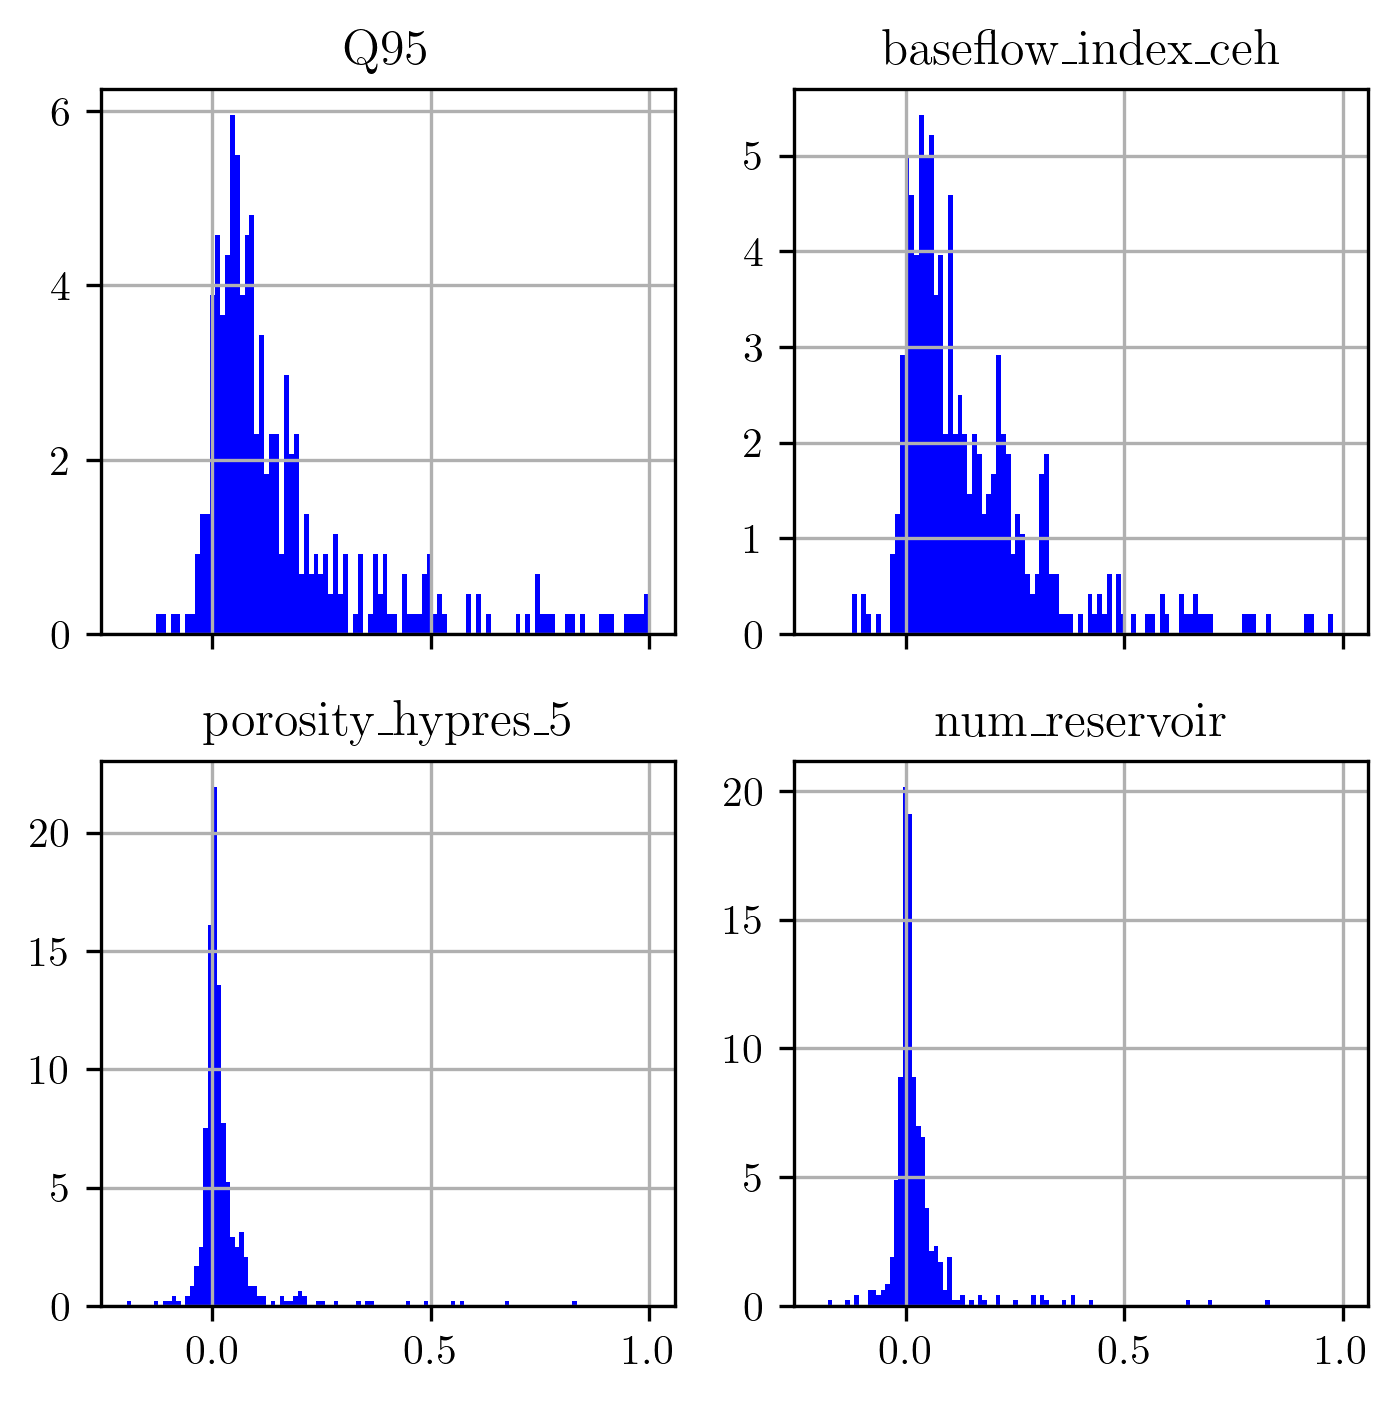

In [233]:
def plot_importances(
    importances: pd.DataFrame,
    feature: str,
    ax: Optional[plt.Axes] = None,
    color: str = "blue",
    label: Optional[str] = None,
):
    x = importances[feature][importances[feature] <= 1]
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.hist(x, facecolor=color, bins=100, density=True, label=label)


fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = ["Q95", "baseflow_index_ceh", "porosity_hypres_5", "num_reservoir"]

save_path = Path("../doc/thesis/figures/permutation/all_features_cv")
save_path.mkdir(exist_ok=True, parents=True)

for i, feature in enumerate(features):
    plot_importances(importance_all_features, feature, ax=axes[i])
    print(
        feature.replace("_", "\\_"),
        feature.replace("_", "\\_").encode(encoding="UTF-8"),
    )
    axes[i].set_title(feature.replace("_", "\_"))
    axes[i].grid()
fig.tight_layout()
"""matplotlib.use("pgf")
matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)
fig.savefig(save_path / "histogram_all.pgf")"""
fig.savefig(save_path / "histogram_all.pdf")
# plt.show()

## The above results seem to imply that the EA-LSTM model likes extra precipitation info.
Possibly because the timeseries do not contain enough information? Or maybe sequence_length should be increased?

## The results below indicate that not many basins care about the "physical" features
This is model dependent, will do the same analysis of the reduced model to see if this is still the case

In [10]:
chosen_features = np.genfromtxt(
    "../runs/correlation_reduction/chosen_features/use_features.txt", dtype="str"
)
# BUG!!
chosen_features = chosen_features[
    np.logical_and(chosen_features != "dpsbar", chosen_features != "dom_land_cover")
]
fracs_all_features.loc[chosen_features, :].sort_values(
    "Amount i > 0.1", ascending=False
)

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
area,222,0.476395,0.94984,0.3365+-0.38,0.0847078
conductivity_hypres,217,0.465665,0.949697,0.3340+-0.39,0.0785232
elev_50,217,0.465665,1.67511,0.3302+-0.39,0.0733852
elev_10,215,0.461373,1.15566,0.3315+-0.39,0.0653507
inwater_perc,212,0.454936,0.949803,0.3351+-0.39,0.0716699
elev_90,211,0.45279,0.99586,0.3324+-0.39,0.0593133
urban_perc,210,0.450644,1.51212,0.3322+-0.40,0.0598893
root_depth,208,0.446352,0.948128,0.3331+-0.39,0.0471242
grass_perc,206,0.44206,1.06044,0.3336+-0.40,0.0440281
dwood_perc,204,0.437768,1.18717,0.3370+-0.40,0.0555751


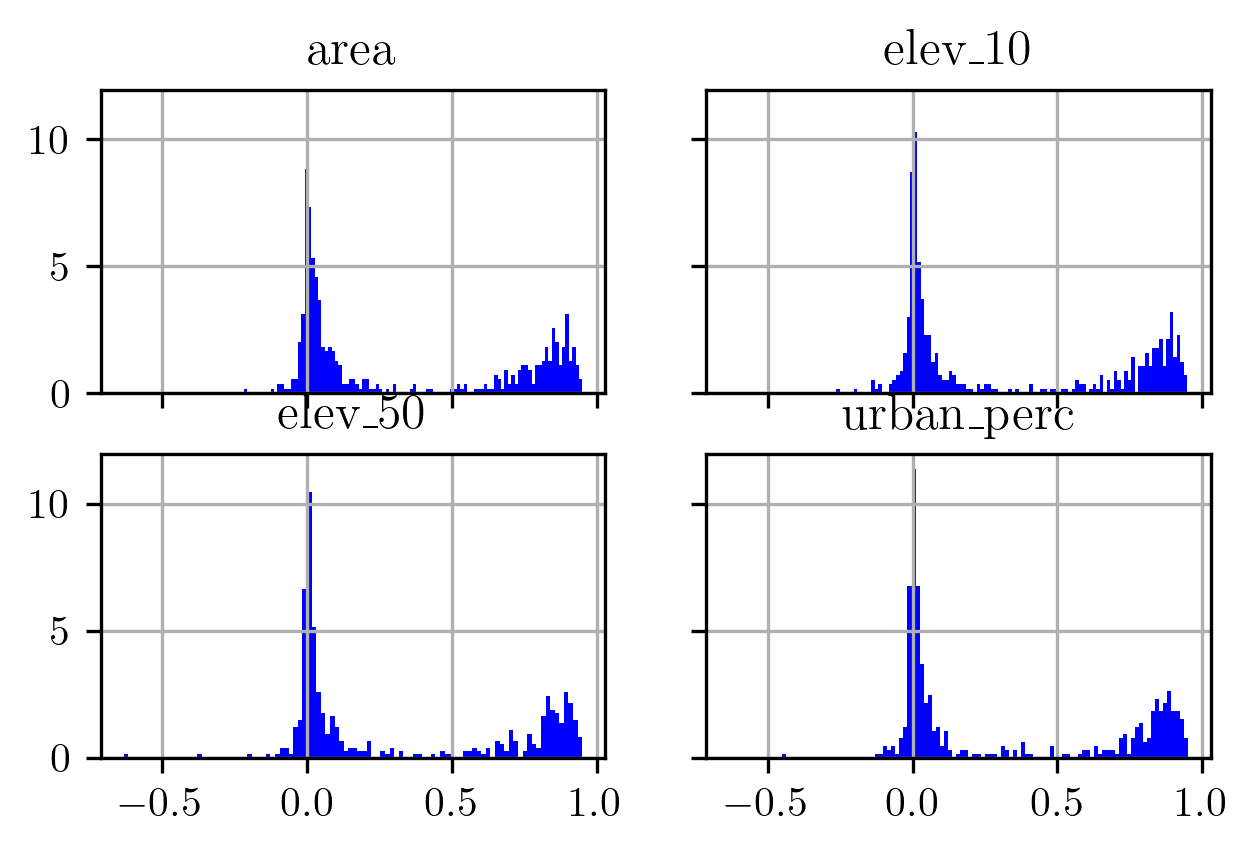

In [11]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.flatten()

features = ["area", "elev_10", "elev_50", "urban_perc"]

for i, feature in enumerate(features):
    plot_importances(importance_all_features, feature, ax=axes[i])
    axes[i].set_title(feature.replace("_", "\_"))
    axes[i].grid()
# fig.tight_layout()
plt.show()

## Importance of reduced, physically based system.

In [12]:
k = 5
permutations_chosen_features = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_cv/permutation/",
    k=k,
)
nse_values_chosen_features = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_cv/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=13,
)
importance_chosen_features = calc_i(
    permutations_chosen_features, nse_values_chosen_features, k=k, min_nse=0.5, epoch=13
)

100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


In [13]:
fracs_chosen_features = importance_metrics(importance_chosen_features, limit=0.1)
fracs_chosen_features

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
no_gw_perc,208,0.497608,19.3248,0.3791+-1.00,0.0979077
conductivity_hypres,200,0.478469,5.82518,0.3392+-0.47,0.0677131
frac_high_perc,195,0.466507,19.8146,0.3894+-1.05,0.0633796
inwater_perc,195,0.466507,1.50543,0.3166+-0.43,0.065994
elev_10,194,0.464115,90.4419,0.5451+-4.42,0.0464568
crop_perc,193,0.461722,31.6257,0.3979+-1.58,0.0540844
urban_perc,190,0.454545,0.998808,0.2868+-0.76,0.0547107
tawc,189,0.452153,0.963123,0.3220+-0.39,0.0524693
frac_low_perc,189,0.452153,4.56305,0.3329+-0.45,0.0583459
area,189,0.452153,0.943094,0.3183+-0.38,0.0627146


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


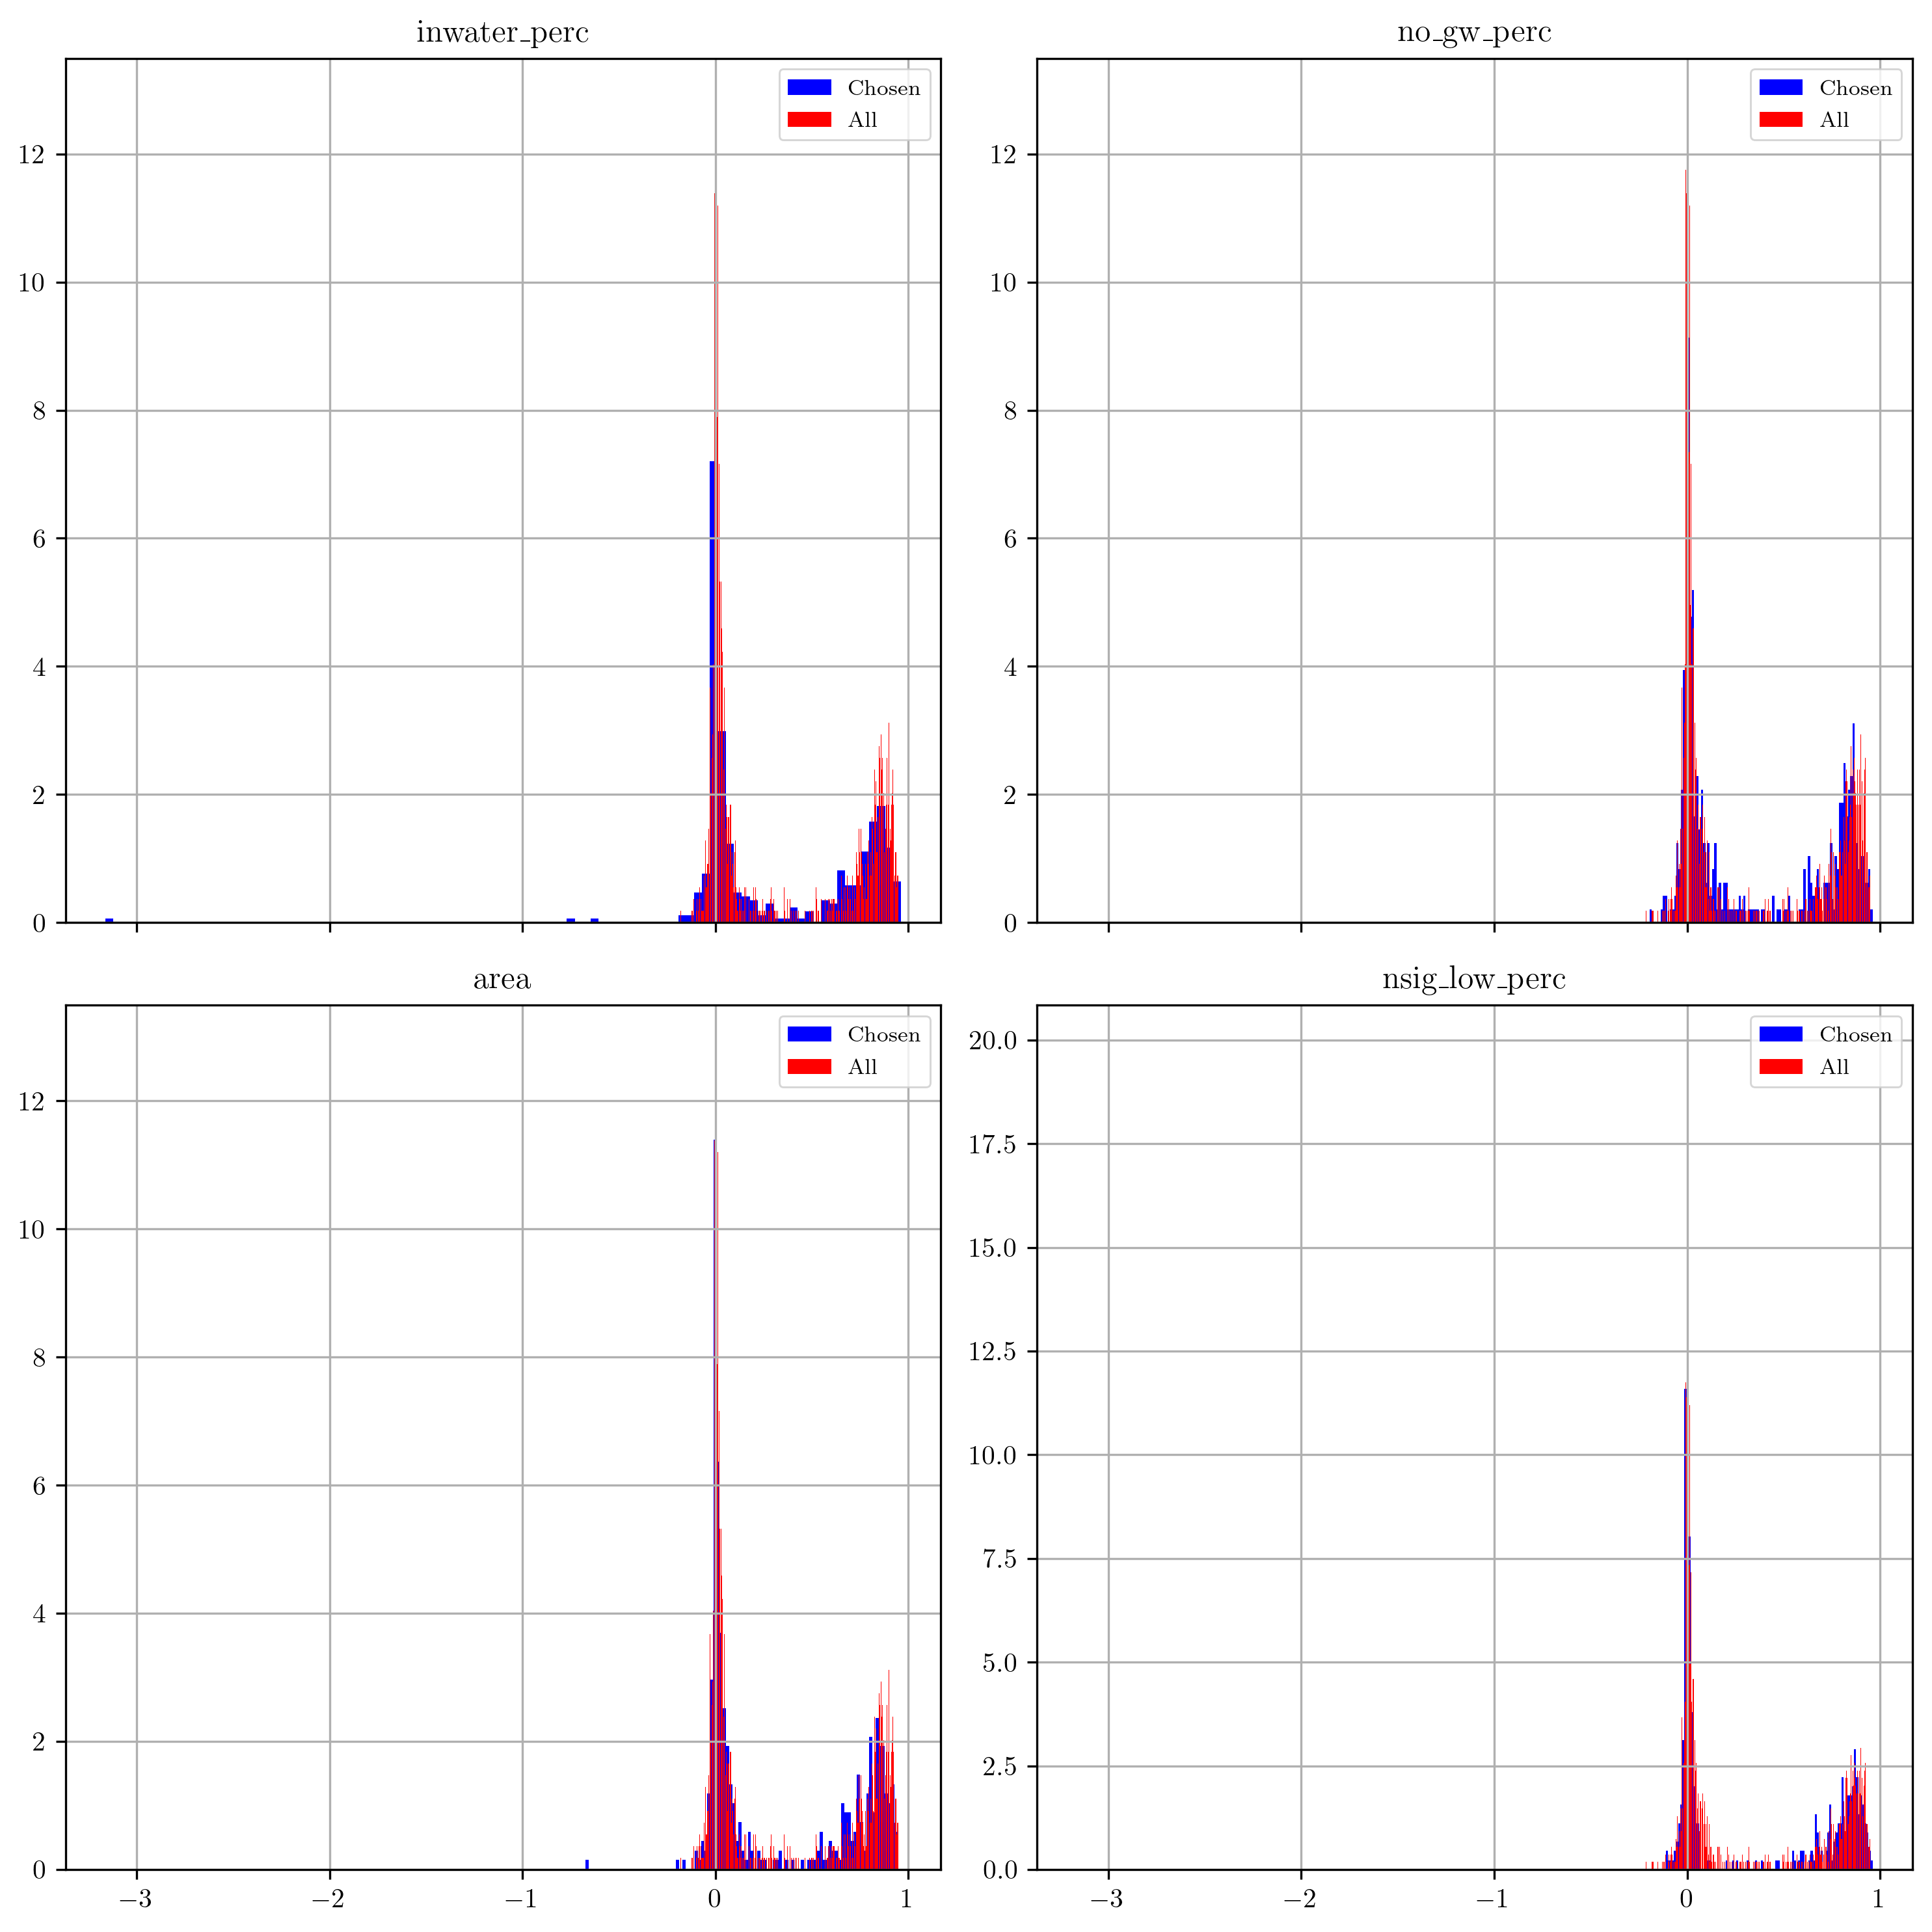

In [14]:
fig, axes = plt.subplots(
    2, 2, sharex=True, sharey=False, figsize=[10, 10]
)  # , figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = ["inwater_perc", "no_gw_perc", "area", "nsig_low_perc"]

for i, feature in enumerate(features):
    plot_importances(
        importance_chosen_features, feature, ax=axes[i], color="blue", label="Chosen"
    )
    plot_importances(
        importance_all_features, features, ax=axes[i], color="red", label="All"
    )
    axes[i].legend()
    axes[i].set_title(feature.replace("_", "\_"))
    axes[i].grid()
fig.tight_layout()
plt.show()

## Importance of fixed all feature run

In [15]:
k = 5
permutations_all_features_fixed = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_fixed_cv/permutation/",
    k=k,
)
nse_values_all_features_fixed = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_fixed_cv/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=20,
)
importance_all_features_fixed = calc_i(
    permutations_all_features_fixed,
    nse_values_all_features_fixed,
    k=k,
    min_nse=0.7,
    epoch=20,
)

100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


In [16]:
fracs_all_features_fixed = importance_metrics(importance_all_features_fixed, limit=0.1)
fracs_all_features_fixed

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
inwater_perc,163,0.467049,1.31303,0.3442+-0.40,0.0424704
frac_high_perc,159,0.455587,2.36039,0.3502+-0.41,0.0560707
area,159,0.455587,0.953965,0.3412+-0.40,0.0474951
conductivity_hypres,156,0.446991,2.7376,0.3470+-0.42,0.0418955
urban_perc,154,0.441261,0.954694,0.3433+-0.40,0.0305211
elev_50,151,0.432665,1.22407,0.3420+-0.41,0.0314661
tawc,150,0.429799,1.04598,0.3398+-0.40,0.0373511
elev_10,150,0.429799,0.948271,0.3389+-0.40,0.0313388
gauge_northing,149,0.426934,2.07553,0.3468+-0.42,0.0262998
low_prec_dur,149,0.426934,0.945446,0.3393+-0.40,0.0357119


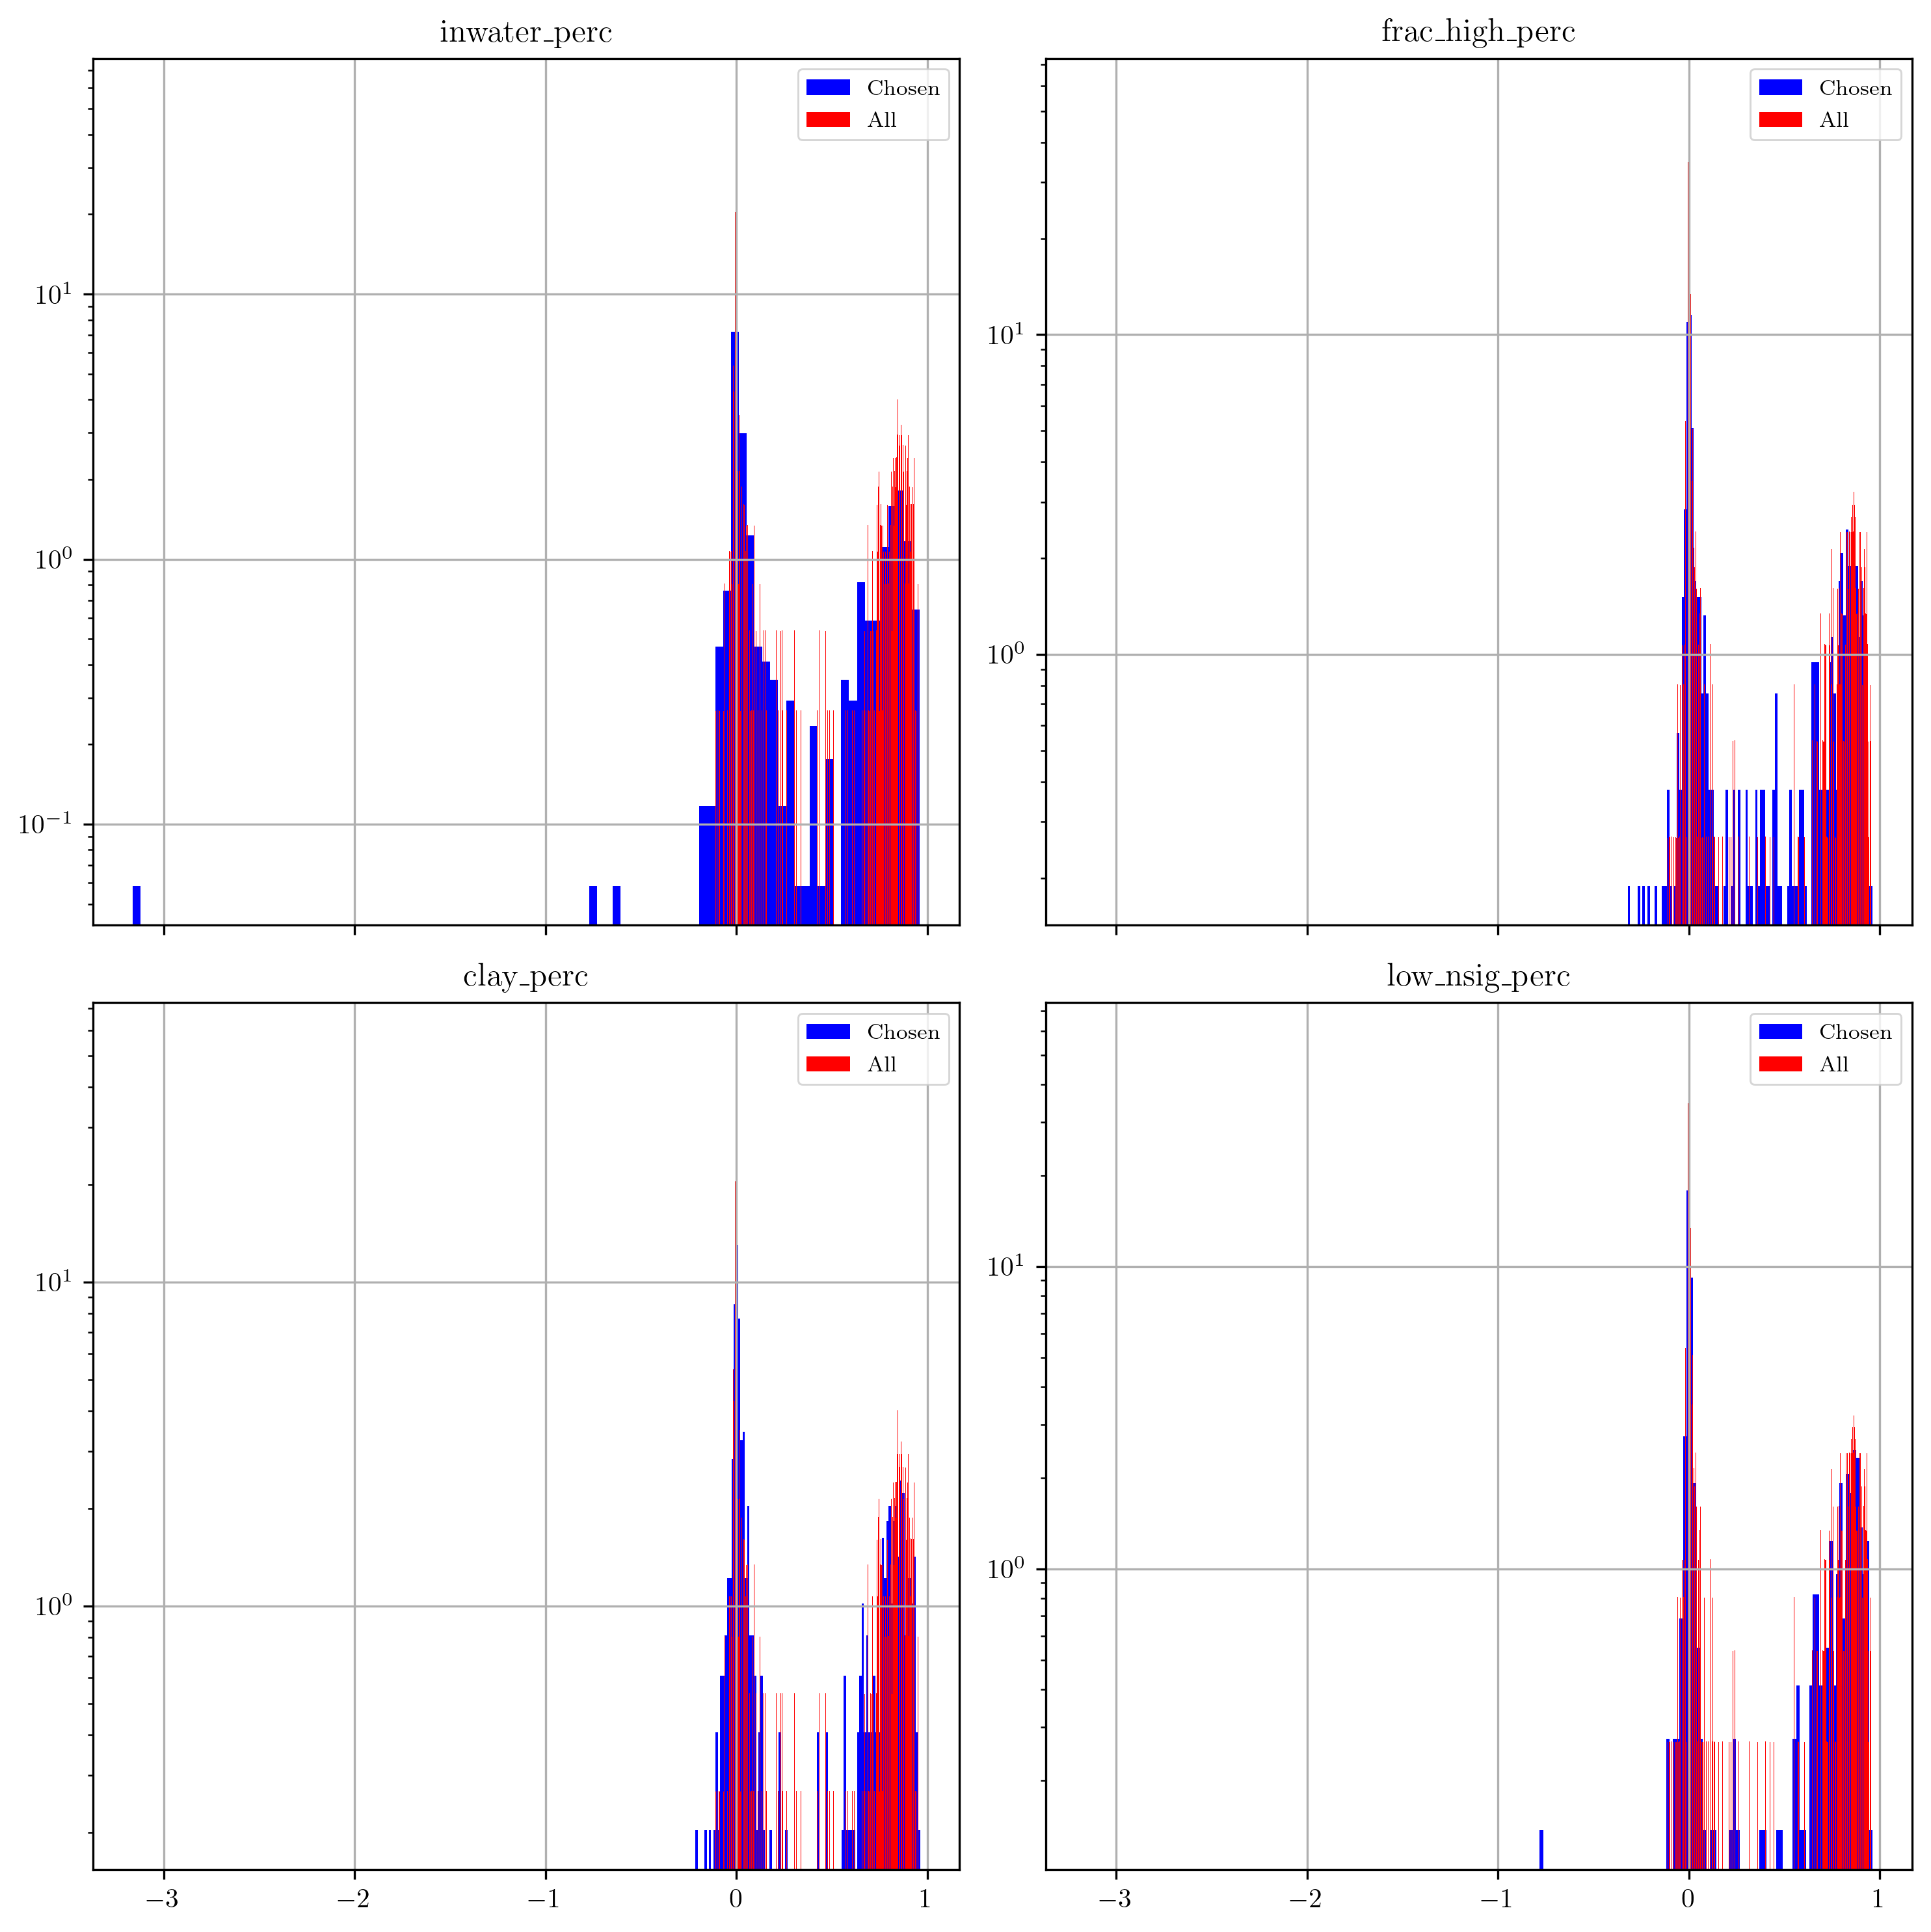

In [17]:
fig, axes = plt.subplots(
    2, 2, sharex=True, sharey=False, figsize=[10, 10]
)  # , figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = ["inwater_perc", "frac_high_perc", "clay_perc", "low_nsig_perc"]

for i, feature in enumerate(features):
    plot_importances(
        importance_chosen_features, feature, ax=axes[i], color="blue", label="Chosen"
    )
    plot_importances(
        importance_all_features_fixed, features, ax=axes[i], color="red", label="All"
    )
    axes[i].legend()
    axes[i].set_title(feature.replace("_", "\_"))
    axes[i].grid()
    axes[i].set_yscale("log")
fig.tight_layout()
plt.show()

## Importance CAMELS-US vs CAMELS-GB
### CAMELS-US:

There is a bug in the permutation test code that caused the test to skip root_depth in camels-us...

In [18]:
k = 5
permutations_common_features_us = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_us/permutation/",
    k=k,
)
nse_values_common_features_us = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_us/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=20,
)
importance_common_features_us = calc_i(
    permutations_common_features_us,
    nse_values_common_features_us,
    k=k,
    min_nse=0.7,
    epoch=20,
)

100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


In [19]:
fracs_common_features_us = importance_metrics(importance_common_features_us, limit=0.1)
fracs_common_features_us

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
clay_frac,68,0.519084,0.798219,0.2811+-0.33,0.107361
elev_mean,67,0.51145,1.14441,0.1994+-0.70,0.10348
area_gages2,67,0.51145,0.869551,0.3064+-0.33,0.108447
sand_frac,66,0.503817,1.02403,0.3165+-0.34,0.108815
soil_conductivity,62,0.473282,2.30253,0.3039+-0.38,0.0761636
silt_frac,60,0.458015,0.857752,0.2847+-0.36,0.0624715
soil_depth_pelletier,58,0.442748,4.92582,0.3129+-0.54,0.0578798
organic_frac,55,0.419847,0.861159,0.2749+-0.43,0
water_frac,52,0.396947,0.861159,0.2905+-0.37,0


### CAMELS-GB:

In [20]:
k = 5
permutations_common_features_gb = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_gb/permutation/",
    k=k,
)
nse_values_common_features_gb = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_gb/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=20,
)
importance_common_features_gb = calc_i(
    permutations_common_features_gb,
    nse_values_common_features_gb,
    k=k,
    min_nse=0.7,
    epoch=20,
)

100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


In [21]:
fracs_common_features_gb = importance_metrics(importance_common_features_gb, limit=0.1)
fracs_common_features_gb

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
root_depth,195,0.571848,28.8013,0.4679+-1.60,0.197113
clay_perc,185,0.542522,75.572,0.5935+-4.10,0.151536
conductivity_cosby,171,0.501466,2.23905,0.3662+-0.40,0.1104
elev_50,164,0.480938,1.0119,0.3423+-0.38,0.0619365
organic_perc,159,0.466276,1.58214,0.3440+-0.39,0.0557728
area,157,0.460411,0.926749,0.3324+-0.38,0.0631702
inwater_perc,150,0.439883,0.92559,0.3196+-0.39,0.0348152
silt_perc,150,0.439883,1.48982,0.3376+-0.40,0.0415422
soil_depth_pelletier,148,0.434018,0.928095,0.3326+-0.40,0.0215025
sand_perc,142,0.416422,0.932458,0.3271+-0.40,0.0239535


Skipped root_depth in CAMELS-US


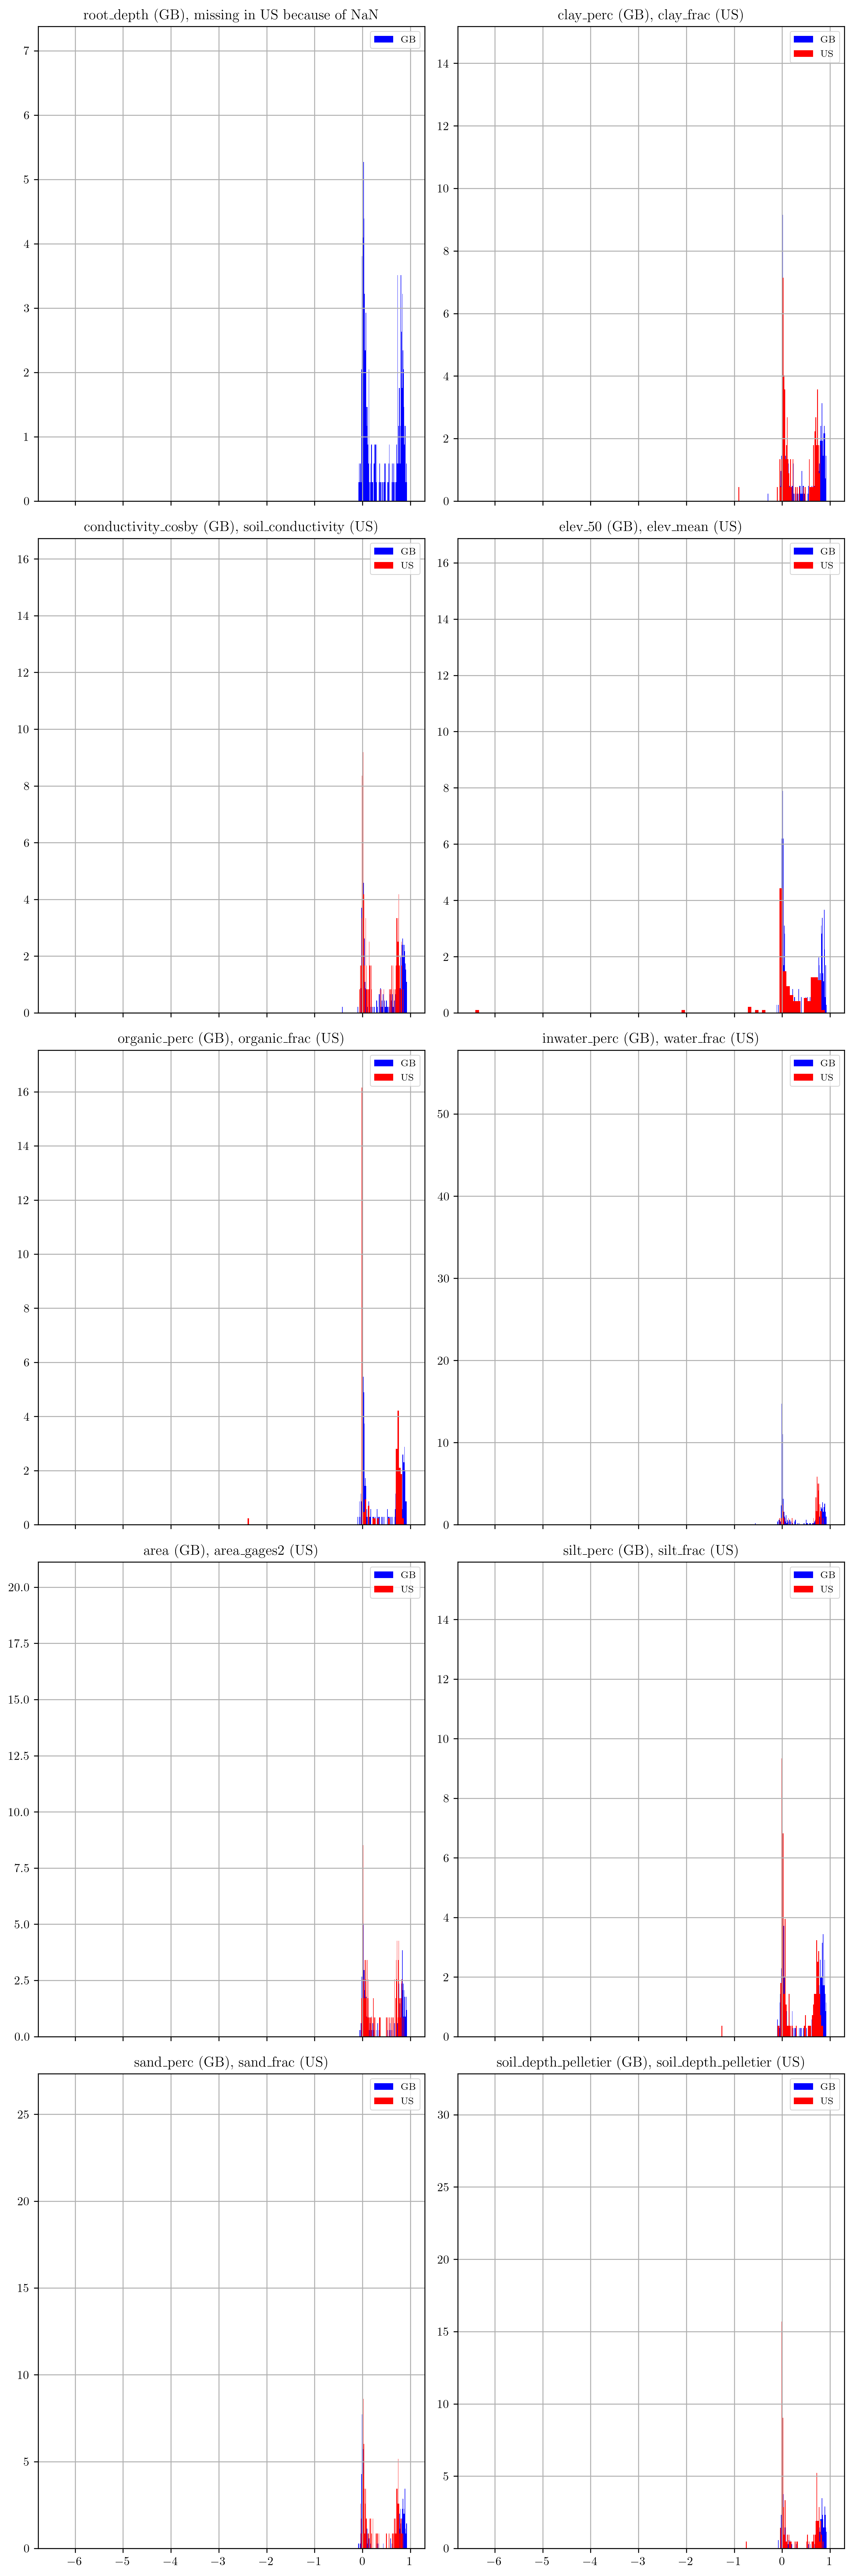

In [22]:
fig, axes = plt.subplots(
    5, 2, sharex=True, sharey=False, figsize=[10, 30]
)  # , figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = {
    "root_depth": "missing",
    "clay_perc": "clay_frac",
    "conductivity_cosby": "soil_conductivity",
    "elev_50": "elev_mean",
    "organic_perc": "organic_frac",
    "inwater_perc": "water_frac",
    "area": "area_gages2",
    "silt_perc": "silt_frac",
    "sand_perc": "sand_frac",
    "soil_depth_pelletier": "soil_depth_pelletier",
}

for i, feature in enumerate(features.keys()):
    plot_importances(
        importance_common_features_gb, feature, ax=axes[i], color="blue", label="GB"
    )
    axes[i].set_title(
        f"{feature} (GB), missing in US because of NaN".replace("_", "\_")
    )
    try:
        plot_importances(
            importance_common_features_us,
            features[feature],
            ax=axes[i],
            color="red",
            label="US",
        )
        axes[i].set_title(
            f"{feature} (GB), {features[feature]} (US)".replace("_", "\_")
        )
    except KeyError:
        print(f"Skipped {feature} in CAMELS-US")
    axes[i].legend()

    axes[i].grid()
    # axes[i].set_yscale("log")
fig.tight_layout()
plt.show()

### Kratzert third paper features

In [23]:
k = 5
permutations_kratzert_features_us = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/kratzert_features_cv_us/permutation/",
    k=k,
    skip=0,
)
nse_values_kratzert_features_us = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/camels_us/kratzert_features_cv_us/",
    model_type="lstm",
    seed="19970204",
    k=k,
    epoch=30,
)
importance_kratzert_features_us = calc_i(
    permutations_kratzert_features_us,
    nse_values_kratzert_features_us,
    k=k,
    min_nse=0.7,
    epoch=30,
    skip=0,
)

100%|██████████| 5/5 [00:12<00:00,  2.47s/it]

skipped 0!


fracs_kratzert_features_us = importance_metrics(
    importance_kratzert_features_us, limit=0.1
)
fracs_kratzert_features_us

## Notes on feature importances
Kratzert et al did not run a static feature importance analysis on the third paper (the one with testing on ungauged basins). On the second paper when he ran a feature importance analysis he observed that mean precipitation was the most important feature. To me this could in theory imply that the gauged basin model uses the mean precipitation as a simple way to "recognize" each basin (this possibility Felix mentioned earlier too). My results here indicate that the snow fraction is more important than in Kratzert's analysis. What these results do agree with however is that hydrological information is more important than land coverage and soil attributes. A bit dissapointing for physical understanding, perhaps? Could always train a new model without these hydrological features to see how that performs, though!

Also, the fact that static information about precipitation like high_prec_frec is still deemed important to me implies that there is potential for improving our LSTM model in the future. All that information should be able to be taken from the time series, implying to me that the LSTM has potential to learn more time dependencies than it does now. 

## Combined dataset. Some notes.

* Times series are differnent. Only 3 in common. (I use 6 right now for CAMELS-GB, Kratzert uses 5 for CAMELS-US)
    - This I already knew though, and it would be interesting to look at a reduced set of itme series anyway.
* Land coverage information is structured differently. 
    - CAMELS-US only has fractions for the dominant land cover for each basin. CAMELS-GB has much more information here as it contains fractions from several land covers.
* There are some attributes I think could be comparable to each other. 
    - |CAMELS-US | CAMELS-GB |
      |-------------------|-----------------|
      |sand_frac|sand_perc|
      |silt_frac|silt_perc|
      |clay_frac|clay_perc|
      |organic_frac|organic_perc|
      |max_water_content|tawc (unsure)|
      |root_depth_XX|root_depth (Both are available as percentiles)|
      |soil_depth_pelletier|soil_depth_pelletier|
      |soil_conductivity|conductivity_(hypres or cosby?)|
      |soil_porosity|soil_porosity_(hypres or cosby?)|
      |||



Camels US: Dominating land cover [string],   CAMELS GB: all land covers
           coverage fraction of dominating,  coverage fraction of several types
           
This leads to:

1: The model gets the fraction of dominating, but no context for it.

2: Same as above, but also include land cover type as input (this input is non-numerical)

In [24]:
k = 5
permutations_mixed = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/combined_dataset/mixed/permutation/",
    k=k,
)
nse_values_mixed = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/combined_dataset/mixed/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=30,
)

100%|██████████| 5/5 [00:33<00:00,  6.79s/it]


In [63]:
def calc_i_transfer(
    permutations: List,
    nse_values: Dict,
    epoch: int = 30,
    k: int = 5,
    min_nse=0,
    skip: Optional[Union[int, List[int]]] = None,
) -> pd.DataFrame:
    if isinstance(skip, int):
        skip = [skip]
    if isinstance(skip, list):
        dividor = k - len(skip)
    else:
        dividor = k
    nse_values = nse_values[f"epoch_{epoch}"]
    means = defaultdict(lambda: defaultdict(lambda: 0))
    index = -1
    for i in range(k):
        if not skip is None and i in skip:
            print(f"skipped {i}!")
            continue
        else:
            index += 1
        fold = permutations[index]
        features = list(fold.keys())
        for feature in features:
            feature_results = fold[feature]
            for k_ in list(feature_results.keys()):
                for basin in feature_results[k_].keys():
                    feature_results[k_][basin]
                    means[feature][basin] += feature_results[k_][basin] / (
                        len(list(feature_results.keys())) * dividor
                    )
        for feature in features:
            for basin in means[feature].keys():
                if nse_values[basin] >= min_nse:
                    means[feature][basin] = nse_values[basin] - means[feature][basin]
                else:
                    means[feature][basin] = np.nan

    return pd.DataFrame.from_dict(means).dropna()

In [26]:
importance_mixed = calc_i_transfer(
    permutations_mixed,
    nse_values_mixed,
    k=k,
    min_nse=0,
    epoch=30,
)
importance_mixed

,soil_depth_pelletier,frac_forest,gvf_max,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,area,porosity_cosby,conductivity_cosby,sand_perc,silt_perc,clay_perc,organic_perc
us_03384450,0.347670,0.335806,0.359019,0.354006,0.346765,0.376827,0.360057,0.359537,0.366203,0.365549,0.355188,0.356154,0.359478,0.380654,0.376969,0.372428,0.338389,0.365035,0.363434
us_06892000,0.512400,0.528065,0.542400,0.529698,0.534296,0.525129,0.530325,0.527709,0.529663,0.529728,0.529094,0.528633,0.552220,0.511679,0.514690,0.516780,0.520603,0.519662,0.530786
us_06339100,0.023343,0.039200,0.024098,0.036061,0.066525,0.012036,0.037507,0.034391,0.063985,0.015410,0.038049,0.032703,0.060524,0.037661,0.020061,0.033667,0.021683,0.028147,0.044574
us_13235000,0.649310,0.661592,0.669222,0.644522,0.669964,0.652639,0.737006,0.643911,0.661185,0.718742,0.687581,0.680566,0.723288,0.656031,0.657260,0.642685,0.669328,0.679323,0.654328
us_07335700,0.500933,0.506703,0.508226,0.505088,0.515241,0.499583,0.514706,0.500987,0.506452,0.503465,0.500233,0.501878,0.529047,0.505474,0.501118,0.501377,0.503721,0.500338,0.500855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gb_36006,0.639276,0.649780,0.651291,0.643159,0.636705,0.643868,0.652342,0.680519,0.652638,0.642801,0.663934,0.640998,0.688327,0.640276,0.633315,0.631907,0.657722,0.667000,0.637061
gb_81007,0.669958,0.668309,0.700169,0.666734,0.667574,0.669127,0.668717,0.673405,0.678492,0.675772,0.672263,0.667036,0.669695,0.667511,0.670844,0.668743,0.675267,0.667210,0.667331
gb_13005,0.629068,0.653181,0.633927,0.665505,0.626010,0.728128,0.616055,0.655280,0.653381,0.631078,0.894914,0.642925,0.635841,0.627475,0.628522,0.636168,0.640593,0.631004,0.618489
gb_27026,0.619040,0.614427,0.657246,0.638690,0.627829,0.636316,0.616201,0.658758,0.618399,0.608472,0.663916,0.617566,0.626410,0.621477,0.611546,0.670959,0.636347,0.623148,0.636930


In [27]:
fracs_mixed = importance_metrics(importance_mixed, limit=0.1)
fracs_mixed

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
organic_perc,704,0.902564,5.64077,0.3834+-0.33,0.394413
low_prec_dur,697,0.89359,1.09054,0.3786+-0.29,0.409768
silt_perc,696,0.892308,2.86914,0.3865+-0.29,0.405077
sand_perc,694,0.889744,1.54035,0.3821+-0.27,0.404249
porosity_cosby,694,0.889744,4.77689,0.2903+-2.60,0.40805
high_prec_dur,693,0.888462,2.40411,0.3695+-0.39,0.396341
clay_perc,689,0.883333,3.58665,0.3841+-0.29,0.408458
low_prec_freq,687,0.880769,2.51824,0.3631+-1.04,0.412391
p_mean,686,0.879487,1.36503,0.3003+-2.20,0.400764
soil_depth_pelletier,685,0.878205,2.27683,0.3802+-0.28,0.403762


In [28]:
def split_importances(importance_mixed: pd.DataFrame) -> pd.DataFrame:
    importance_us = importance_mixed[importance_mixed.index.str.contains("us")]
    importance_gb = importance_mixed[importance_mixed.index.str.contains("gb")]
    return importance_us, importance_gb

In [29]:
importance_mixed_us, importance_mixed_gb = split_importances(importance_mixed)

In [30]:
fracs_mixed_us = importance_metrics(importance_mixed_us, limit=0.1)
fracs_mixed_us

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
organic_perc,296,0.880952,0.748288,0.3474+-0.23,0.361641
sand_perc,295,0.877976,0.907004,0.3481+-0.23,0.366749
porosity_cosby,292,0.869048,0.763727,0.3469+-0.23,0.363657
high_prec_dur,292,0.869048,0.787803,0.3469+-0.23,0.364274
silt_perc,291,0.866071,0.770642,0.3465+-0.23,0.371349
low_prec_dur,290,0.863095,0.804715,0.3480+-0.24,0.355256
gvf_max,289,0.860119,0.918798,0.3487+-0.23,0.364272
low_prec_freq,288,0.857143,0.770341,0.3444+-0.23,0.35558
conductivity_cosby,287,0.854167,1.24866,0.3510+-0.24,0.372306
clay_perc,286,0.85119,0.797681,0.3451+-0.24,0.36653


In [31]:
fracs_mixed_gb = importance_metrics(importance_mixed_gb, limit=0.1)
fracs_mixed_gb

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
organic_perc,408,0.918919,5.64077,0.4107+-0.39,0.453691
low_prec_dur,407,0.916667,1.09054,0.4018+-0.32,0.467591
silt_perc,405,0.912162,2.86914,0.4169+-0.33,0.470577
clay_perc,403,0.907658,3.58665,0.4136+-0.32,0.476093
p_mean,403,0.907658,1.36503,0.2689+-2.91,0.468479
area,403,0.907658,1.20976,0.4110+-0.27,0.4736
porosity_cosby,402,0.905405,4.77689,0.2475+-3.44,0.463014
high_prec_dur,401,0.903153,2.40411,0.3866+-0.48,0.4698
soil_depth_pelletier,400,0.900901,1.34185,0.4027+-0.30,0.466656
low_prec_freq,399,0.898649,2.51824,0.3773+-1.37,0.467998


In [32]:
k = 5
permutations_train_us_val_gb_no_organic_no_gvf = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/combined_dataset/train_us_val_gb_no_organic_no_gvf/permutation/",
    k=k,
)

nse_values_train_us_val_gb_no_organic_no_gvf = defaultdict(lambda: defaultdict(int))

for i in tqdm(range(k)):  # (range(1, 3)):  # Remember to fix
    results_ = load_results(
        folder=f"/home/bernhard/git/Master-Thesis/runs/combined_dataset/train_us_val_gb_no_organic_no_gvf/val_gb/{i}",
        model_type="ealstm",
        seed="19970204",
    )
    for epoch in results_:
        for basin in results_[epoch]:
            nse_values_train_us_val_gb_no_organic_no_gvf[epoch][basin] += (
                results_[epoch][basin] / k
            )

100%|██████████| 5/5 [01:37<00:00, 19.53s/it]


In [33]:
importance_train_us_val_gb_no_organic_no_gvf = calc_i_transfer(
    permutations_train_us_val_gb_no_organic_no_gvf,
    nse_values_train_us_val_gb_no_organic_no_gvf,
    k=k,
    min_nse=0.5,
    epoch=14,
)
importance_train_us_val_gb_no_organic_no_gvf

,soil_depth_pelletier,frac_forest,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,area,porosity_cosby,conductivity_cosby,sand_perc,silt_perc,clay_perc
gb_73014,0.604657,0.609696,0.575546,0.612053,0.603045,0.597359,0.624514,0.613712,0.602021,0.606235,0.602386,0.595403,0.610431,0.608008,0.609337,0.599475,0.610039
gb_63004,0.624992,0.637346,0.608515,0.646437,0.628921,0.624464,0.659771,0.614235,0.637576,0.615946,0.620497,0.616527,0.632731,0.632283,0.631550,0.630523,0.629908
gb_82001,0.552553,0.546800,0.549983,0.553882,0.547278,0.561147,0.547587,0.553299,0.547601,0.564987,0.535331,0.589677,0.559888,0.551900,0.547734,0.538090,0.534848
gb_96001,0.452060,0.450801,0.459483,0.460750,0.455468,0.432345,0.476338,0.453376,0.457733,0.468524,0.451997,0.454381,0.454291,0.461912,0.451302,0.442477,0.444757
gb_84017,0.597733,0.612440,0.604839,0.619355,0.602814,0.600957,0.619287,0.611884,0.607387,0.671557,0.624581,0.606862,0.600167,0.592714,0.599956,0.598234,0.604391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gb_72015,0.570862,0.570718,0.570026,0.572788,0.572241,0.574481,0.583883,0.572856,0.579372,0.575732,0.571051,0.581749,0.573417,0.573884,0.573278,0.573917,0.571734
gb_27084,0.480297,0.482392,0.487743,0.485076,0.477932,0.479023,0.478258,0.490947,0.486334,0.470466,0.471871,0.490874,0.486063,0.482475,0.480807,0.481089,0.469058
gb_84030,0.528856,0.538657,0.544119,0.543950,0.548897,0.538211,0.559221,0.544570,0.542226,0.541064,0.533482,0.573297,0.541924,0.540809,0.546302,0.539897,0.534104
gb_80005,0.464655,0.452337,0.422116,0.457054,0.453237,0.453631,0.454644,0.457235,0.439521,0.473106,0.463116,0.457545,0.453975,0.457213,0.454248,0.455379,0.460007


In [34]:
fracs_train_us_val_gb_no_organic_no_gvf = importance_metrics(
    importance_train_us_val_gb_no_organic_no_gvf, limit=0.6
)
fracs_train_us_val_gb_no_organic_no_gvf

,Amount i > 0.6,Fraction i > 0.6,Max,|i|,median(i)
low_prec_freq,35,0.243056,0.959584,0.5352+-0.10,0.523591
low_prec_dur,27,0.1875,0.727568,0.5227+-0.08,0.515061
aridity,26,0.180556,0.668073,0.5199+-0.08,0.523431
pet_mean,25,0.173611,0.708141,0.5197+-0.07,0.514782
high_prec_freq,23,0.159722,0.665638,0.5185+-0.07,0.520425
frac_forest,23,0.159722,0.667383,0.5181+-0.07,0.51515
high_prec_dur,22,0.152778,0.676701,0.5151+-0.07,0.510786
p_seasonality,22,0.152778,0.670517,0.5150+-0.07,0.513206
porosity_cosby,22,0.152778,0.673297,0.5173+-0.07,0.514342
conductivity_cosby,21,0.145833,0.697019,0.5160+-0.07,0.510679


In [168]:
k = 4
permutations_all_features_concat_seq_len_gb = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_concat_seq_len_cv/permutation/",
    k=k,
)


nse_values_common_features_gb = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_concat_seq_len_cv/",
    model_type="lstm",
    seed="19970204",
    k=k,
    epoch=15,
)

100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


In [226]:
importance_all_features_concat_seq_len_cv = calc_i(
    permutations_all_features_concat_seq_len_gb,
    nse_values_common_features_gb,
    k=k,
    min_nse=0.5,
    epoch=15,
)
importance_all_features_concat_seq_len_cv

,num_reservoir,reservoir_cap,dwood_perc,ewood_perc,grass_perc,shrub_perc,crop_perc,urban_perc,inwater_perc,bares_perc,...,clay_perc,organic_perc,bulkdens,tawc,porosity_cosby,porosity_hypres,conductivity_cosby,conductivity_hypres,root_depth,soil_depth_pelletier
56012,-0.002157,0.000000,0.029004,-2.289951e-02,-0.002889,-0.002721,0.008372,-0.003764,-0.002254,0.000192,...,0.000090,-0.003102,0.014420,0.032728,-0.006100,-0.004046,0.000117,-0.001431,2.502548e-02,0.002810
54004,-0.006968,0.000000,-0.031391,-2.719448e-03,-0.004548,0.000170,-0.027574,0.124019,0.004782,-0.000002,...,-0.004288,-0.006821,0.021818,0.034974,-0.000628,-0.003759,-0.005649,0.028062,-4.693973e-03,0.000485
28015,0.507943,-0.034447,1.005530,-4.356739e-02,-0.185901,0.005234,-0.063649,-0.037938,-0.002964,0.177591,...,-0.189248,0.000017,-0.034548,-0.072697,0.035495,-0.163038,0.125436,0.161182,-2.719473e-02,-0.182587
36009,0.000000,0.000000,0.014944,2.255050e-05,0.010836,-0.000385,-0.014307,0.011727,0.006416,-0.000815,...,0.146432,-0.000039,-0.016108,0.029788,0.061281,0.002601,0.174488,0.095206,1.368750e-02,0.044701
56002,-0.000063,0.000000,0.000871,2.878968e-03,0.013546,0.001790,0.041187,-0.011116,-0.009302,0.002642,...,-0.008376,0.000205,-0.000738,0.003611,-0.000347,0.000845,0.011782,-0.007717,-5.446264e-07,0.002636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72004,0.000000,0.000000,0.001192,7.709602e-07,0.001851,0.003167,0.000278,-0.000280,0.027719,0.004926,...,0.000913,-0.000769,0.019451,0.006496,0.019969,-0.000025,0.000200,-0.000739,3.575824e-02,-0.000058
39007,0.000000,0.000000,0.027387,1.251381e-02,0.191355,-0.005614,0.016646,0.085980,0.171931,0.000105,...,0.003114,-0.001172,0.060647,-0.000459,0.000528,0.020509,-0.004813,0.035974,-1.049294e-02,-0.010808
82003,0.000000,0.000000,0.058019,-5.602238e-02,-0.019050,-0.029626,-0.026446,0.003937,0.015266,-0.001118,...,0.040478,-0.005823,-0.023848,-0.016014,-0.000254,-0.004982,0.027229,0.010224,-1.214787e-02,-0.002337
37001,0.000000,0.000000,0.012107,3.725415e-05,0.003095,-0.000909,0.041927,0.063342,-0.002937,-0.000646,...,0.030376,-0.001239,0.022467,-0.013479,-0.022239,0.042783,0.074316,0.231357,-2.480874e-02,0.004205


In [227]:
fracs_all_features_concat_seq_len_cv = importance_metrics(
    importance_all_features_concat_seq_len_cv, limit=0.1
)
fracs_all_features_concat_seq_len_cv

,Amount i > 0.1,Fraction i > 0.1,Max,|i|,median(i)
low_prec_dur,69,0.204748,0.740267,0.0531+-0.10,0.0210259
low_prec_freq,52,0.154303,0.868128,0.0592+-0.14,0.0176751
inwater_perc,38,0.11276,1.45806,0.0519+-0.18,0.00468009
frac_high_perc,35,0.103858,1.17823,0.0387+-0.13,0
conductivity_hypres,34,0.10089,0.499161,0.0268+-0.08,0.00393564
root_depth,33,0.0979228,5.19504,0.0525+-0.32,0.00423131
p_seasonality,26,0.0771513,0.559659,0.0237+-0.07,0.00482666
grass_perc,25,0.074184,1.08769,0.0287+-0.11,0.00674536
frac_snow,25,0.074184,1.09294,0.0257+-0.10,0.00308808
elev_10,25,0.074184,0.913299,0.0242+-0.08,0.00490156


In [228]:
def boxplot_feature_importance(
    importances: pd.DataFrame, features: List[str], ax: Optional[plt.Axes] = None
):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.boxplot(importances[features])
    ax.set_xticklabels([feature.replace("_", "\_") for feature in features], rotation=0)
    # ax.set_yscale("log")
    ax.grid("on")

(-0.1, 1.0)

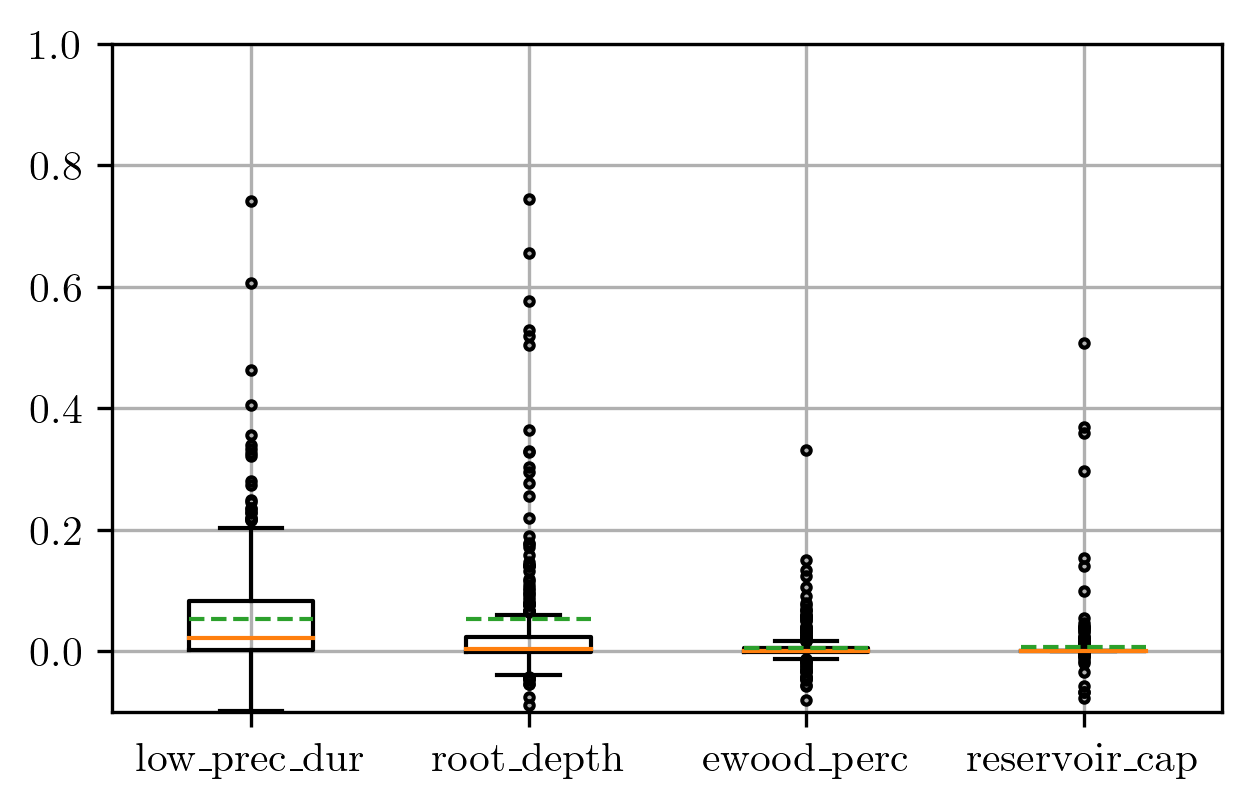

In [229]:
fig, ax = plt.subplots(1, 1)
boxplot_feature_importance(
    importances=importance_all_features_concat_seq_len_cv,
    features=["low_prec_dur", "root_depth", "ewood_perc", "reservoir_cap"],
    ax=ax,
)
ax.set_ylim([-0.1, 1])